<img src="guro.png" alt="Drawing" style="width: 250px; margin-left:-1px;"/>


# Ayudantía 3: Gurobi

* Felipe Cornejo - facornejo@uc.cl
* Sebastián Barriga - sabarriga@uc.cl

### Guía de instalación:

1. Tener instalado python
2. Registrarse en gurobi con el mail UC [https://www.gurobi.com/es/]
3. Descargar Gurobi [http://www.gurobi.com/downloads/gurobi-optimizer]
4. Pedir Licencia académica [http://www.gurobi.com/downloads/licenses/license-center]
5. Activar la licencia usando la red wifi UC (debe hacerse desde la red de la UC). Siga la documentación [http://www.gurobi.com/documentation/]
6. Instalar Gurobi en Anaconda*.
7. Seguir instrucciones de instalación en [http://www.gurobi.com/documentation/]


*_Si bien no es del todo recomendable instalar anaconda, si facilita el trabajo al incluir la gran mayoría de paquetes necesarios para trabajar con gurobi y análisis de datos._

### Modelando con gurobi
Crear un modelo con gurobi requiere de 6 pasos

* __Crear modelo:__ m = Model( )
* __Agregar Variables:__ x = m.addVar(...)
* __Actualizar cambios:__ m.update( )
* __Fijar func. objetivo:__ m.setObjective(...)
* __Agregar restricciones:__ m.addConstr(...)
* __Optimizar!:__ m.optimize( )

In [313]:
from gurobipy import *

# Ejemplo
Problema proporcionado por [gurobi](https://www.gurobi.com/es/resource/functional-code-examples/)

Formulación matemática de un problema de maximización:



  
  $$max(x + y + 2z)$$
  subject to
        $$x + 2 y + 3 z <= 4$$
        $$x +   y       >= 1$$
        $$x, y, z \hspace{0.3cm}binary$$ 

In [314]:
#!/usr/bin/python
# Copyright 2019, Gurobi Optimization, LLC

# Create a new model
m = Model("mip1")

    # Create variables
x = m.addVar(vtype=GRB.BINARY, name="x")
y = m.addVar(vtype=GRB.BINARY, name="y")
z = m.addVar(vtype=GRB.BINARY, name="z")

    # Set objective
m.setObjective(x + y + 2 * z, GRB.MAXIMIZE)

    # Add constraint: x + 2 y + 3 z <= 4
m.addConstr(x + 2 * y + 3 * z <= 4, "c0")

    # Add constraint: x + y >= 1
m.addConstr(x + y >= 1, "c1")

    # Optimize model
m.optimize()

for v in m.getVars():
    print('%s %g' % (v.varName, v.x))
print(f'Obj: {m.objVal}')

Optimize a model with 2 rows, 3 columns and 5 nonzeros
Variable types: 0 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 2
Presolve removed 2 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 4 available processors)

Solution count 2: 3 2 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%
x 1
y 0
z 1
Obj: 3.0


In [315]:
from random import randint, choice, seed
seed(1)

# Gurobi infeasible model

Cuando creamos nuestros modelos de optimización, ya sea desde su formulación matemática, hasta su implementación en código, existen diferentes razones por las cuáles el problema que hemos modelado puede resultar **infactible**. Considerando que el modelo matemático pueda estar bien escrito; en su mayoría las infactibilidades nacen cuando hemos dejado de considerar **factores importantes que gobiernan el problema**, por ejemplo: los valores de los parámetros, el tipo de restricciones utilizada no describen correctamente el problema, hemos omitido alguna información, etc.

El problema por analizar a continuación, es una adaptación de la documentación de gurobi y tiene los siguientes objetivos:

* Resolver un modelo de asignación de trabajadores a turnos.
* Este modelo en particular es infactible, intentaremos determinar a que se debe.
* Explorar las funciones de gurobi que nos permiten observar que sucede en estos casos.
* Aprovechar la notación y simplificación que hage gurobi para representar modelos de optimización.

## Problema propuesto

Le han solicitado desde su empresa realizar la planificación para los turnos de los trabajadores para las próximas 2 semanas (a contar del día Lunes) y minimizar los costos asociados a esta. Debido al tipo de producción que realiza su empresa, es importante que la planta de operaciones cuente en todo momento con operarios para garantizar su funcionamiento, por lo que usted debe contar con la cantidad necesaria de personal para los 7 días de la semana. La cantidad de personal requerido para operar en las instalaciones de la empresa varía aleatoriamente entre 2 a 7 trabajadores (puede considerarlo una distribución uniforme). Por otra parte, usted dispone de una cantidad limitada de operarios (7 en esta ocación), los cuales tienen diferentes disponibilidades para trabajar en la semana. La disponibilidad de cada trabajador varía entre 5 a 13 días para trabajar en el horizonte de las dos semanas. Asociado a esto, cada trabajador cobra un sueldo por turno trabajado. 

El problema puede ser interpretado por el siguiente modelo matemático:

__Indices:__

* $t$: índice que indica el trabajador $t$
* $s$: índice que indica el turno $s$

__Variables de desición:__
* $X_{t,s}$: Variable binaria, __1__ si el trabajador $t$ es asignado al turno $s$, **0** e.o.c.

__Parámetros:__
* $P_{t}$: Pago asociado al trabajador $t$
* $r_{s}$: Requerimiento del turno $s$

$$min \sum_{t,s} P_{t}X_{t,s}$$

$$\sum_{t,s} X_{t,s} = r_{s} \hspace{0.5cm} \forall s$$

$$n.v. \hspace{0.4cm} X_{t,s} \in {0,1}$$




# Estrategia de modelación:

## Modelo
Creamos el modelo de gurobi con la función Model( )

In [316]:
m = Model("planificacion")

Vamos a crear un horizonte temporal de 2 semanas como enuncia el problema para favorecer su interpretación.

In [317]:
semanas = 2
dias = ["L","M","W","J","V","S","D"]
turnos = [v+str(i+1) for i, v in enumerate(dias*semanas)] # ["L1","M2","W3","J4","V5","S6","D7","L8",...]

Creamos nuestro set de datos, el cual consiste en la lista de trabajadores, sus turnos y disponibilidad. Por otra parte, definimos los requerimientos de trabajadores por turno.

In [318]:
trabajadores = ["Tomas", "Javiera", "Marcelo", "Jorge", "Ana", "Camila", "Diego"]

In [319]:
# pagos asociados
pago = {"Tomas":  10, 
        "Javiera":12, 
        "Marcelo":10, 
        "Jorge":  8, 
        "Ana":    8, 
        "Camila": 9, 
        "Diego":  11}

In [320]:
# requerimientos por turno
requerimientos = {}
for i in turnos:
    requerimientos[i] = randint(2,7)
print(requerimientos)

{'L1': 3, 'M2': 6, 'W3': 2, 'J4': 4, 'V5': 2, 'S6': 5, 'D7': 5, 'L8': 5, 'M9': 7, 'W10': 5, 'J11': 3, 'V12': 2, 'S13': 5, 'D14': 2}


Disponibilidad de los trabajadores

In [321]:
# optimizamos sólo los días disponibles

disponibilidad = []
for trabajador in trabajadores:
    count = 1
    dias_disponibles = randint(5,13)
    while(count <= dias_disponibles):
        while True:
            eleccion = choice(turnos)
            if (trabajador, eleccion) not in disponibilidad:
                disponibilidad.append((trabajador,eleccion))
                break
        count += 1
disponibilidad = tuplelist(disponibilidad)
print(disponibilidad)

<gurobi.tuplelist (75 tuples, 2 values each):
 ( Tomas   , D7  )
 ( Tomas   , W10 )
 ( Tomas   , S13 )
 ( Tomas   , L1  )
 ( Tomas   , V12 )
 ( Tomas   , L8  )
 ( Tomas   , V5  )
 ( Tomas   , J4  )
 ( Tomas   , M2  )
 ( Tomas   , S6  )
 ( Tomas   , J11 )
 ( Javiera , L1  )
 ( Javiera , D7  )
 ( Javiera , J11 )
 ( Javiera , J4  )
 ( Javiera , V12 )
 ( Javiera , M9  )
 ( Javiera , S13 )
 ( Javiera , L8  )
 ( Javiera , S6  )
 ( Javiera , V5  )
 ( Javiera , D14 )
 ( Javiera , M2  )
 ( Javiera , W3  )
 ( Marcelo , M2  )
 ( Marcelo , V12 )
 ( Marcelo , S6  )
 ( Marcelo , M9  )
 ( Marcelo , D7  )
 ( Marcelo , D14 )
 ( Marcelo , J11 )
 ( Marcelo , J4  )
 ( Marcelo , V5  )
 ( Jorge   , W10 )
 ( Jorge   , L8  )
 ( Jorge   , D14 )
 ( Jorge   , M9  )
 ( Jorge   , D7  )
 ( Jorge   , L1  )
 ( Jorge   , J4  )
 ( Jorge   , V12 )
 ( Jorge   , S13 )
 ( Ana     , D7  )
 ( Ana     , J11 )
 ( Ana     , W3  )
 ( Ana     , S6  )
 ( Ana     , M9  )
 ( Ana     , V12 )
 ( Ana     , S13 )
 ( Ana     , M2  )
 ( A

## Variables de decisión

Variable binaria x\[t,s\] = 1 si el trabajador t es asignado al turno s

In [322]:
x = m.addVars(disponibilidad, ub=1, name="x")

## Función Objetivo

Minimizar el salario total

In [348]:
m.setObjective(sum(pago[t]*x[t,s] for t,s in disponibilidad), GRB.MINIMIZE)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


## Restricciones asociadas al problema

Por cada turno, el numero de trabajadores debe ser igual al que se necesita para ese turno.

In [324]:
# La funcion sum es aplicable a tuplas, esta retorna la suma de los valores asociados a determinadas keys.
# El '*' indica que cualquier valor es aceptado en ese campo, si no colocamos argumentos entonces se retorna la suma
# de todos los valores en la tupla
# https://www.gurobi.com/documentation/8.1/refman/py_tupledict_sum.html
reqCts = m.addConstrs((x.sum('*', s) == requerimientos[s] for s in turnos),"_")

In [325]:
# optimizamos

m.optimize()

Optimize a model with 14 rows, 75 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 7e+00]
Presolve removed 2 rows and 32 columns
Presolve time: 0.01s

Solved in 0 iterations and 0.01 seconds
Infeasible model


In [326]:
m.write("file_infeasible.lp")
m.write("file_infeasible.mps")

# Modificando el modelo

* Cambiar coeficientes (objective, RHS, Matrix, Bounds)
* Cambiar Variables (continuas o enteras)
* Agregar/Borrar Varaibles o restricciones
* feasRelaxS permite crear una relajación factible del modelo


La relajación factible es un modelo que, cuando se soluciona, minimiza la cantidad por la cual la solución viola
las cotas y restricciones del problema original. Este metodo provee diferentes opciones para la relajación.


In [327]:
# Argumentos 
# modelo que minimiza la cantidad donde la solucion viola los limites y las restricciones del modelo original
# relaxobjtype: 0 para minimizar la suma de las magnitudes de los limites y restricciones violadas
# relaxobjtype: 1 para minimizar la suma de los cuadrados de limites y restricciones violados
# relaxobjtype: 2 para minimizar la suma total de limites y restricciones violados

# Si una restriccion fuera violada por una cantidad de 2, la funcion contribuye en 2 a la relajacion con 0, 2*2 en 1 y 1 en 2.

# minrelax: booleano que controla el tipo de relajacion creado. False minimiza el costo de la violacion, True encuentra una solucion que minimiza el obejtivo original
# solo a traves de estas soluciones minimiza el costo de la violacion (costoso)

# vrelax: indica si las cotas de las variable pueden ser relajadas
# crelax: indica si las restricciones pueden ser relajadas


orignumvars = m.NumVars
m.feasRelaxS(0, False, False, True)
m.optimize()

Optimize a model with 14 rows, 103 columns and 103 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 7e+00]
Presolve removed 5 rows and 76 columns
Presolve time: 0.01s
Presolved: 9 rows, 27 columns, 27 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0000000e+00   0.000000e+00   0.000000e+00      0s
       0    4.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  4.000000000e+00


Si deseamos ver las variables y los valores que asumen

In [328]:
m.printAttr('X',"Art*")


    Variable            X 
-------------------------
     ArtP_M2            2 
     ArtP_M9            1 
    ArtP_W10            1 


In [329]:
print(m.objVal)

4.0


In [330]:
m.printAttr('X')


    Variable            X 
-------------------------
 x[Tomas,D7]            1 
x[Tomas,W10]            1 
x[Tomas,S13]            1 
 x[Tomas,L8]            1 
 x[Tomas,V5]            1 
 x[Tomas,J4]            1 
 x[Tomas,M2]            1 
 x[Tomas,S6]            1 
x[Javiera,L1]            1 
x[Javiera,D7]            1 
x[Javiera,J4]            1 
x[Javiera,V12]            1 
x[Javiera,M9]            1 
x[Javiera,L8]            1 
x[Javiera,S6]            1 
x[Javiera,D14]            1 
x[Javiera,M2]            1 
x[Marcelo,M2]            1 
x[Marcelo,S6]            1 
x[Marcelo,M9]            1 
x[Marcelo,D7]            1 
x[Marcelo,J11]            1 
x[Marcelo,J4]            1 
x[Jorge,W10]            1 
 x[Jorge,L8]            1 
 x[Jorge,M9]            1 
 x[Jorge,D7]            1 
 x[Jorge,L1]            1 
 x[Jorge,J4]            1 
x[Jorge,S13]            1 
   x[Ana,D7]            1 
  x[Ana,J11]            1 
   x[Ana,W3]            1 
   x[Ana,S6]            1 
   x[Ana,M

In [331]:
m.write("file.lp")

In [332]:
# for c in m.getConstrs():
#     print(m.getRow(c))

In [333]:
# for v in m.getVars():
#     print(v.x)

Para conocer las variables originales

In [334]:
orignumvars

75

También, presentamos un breve interpretación gráfica del problema

In [335]:
import pandas as pd

holguras = m.getVars()[orignumvars:]
data = {
    "dias":[s[:3] for s in turnos],
    "semanas": [1+i/7 for i in range(len(turnos))],
    "holguras": [v.X for v in holguras if v.VarName.startswith("ArtP")]
}
n = int(len(data["holguras"])/semanas)

final = [data["holguras"][i * n:(i + 1) * n] for i in range((len(data["holguras"]) + n - 1)// n )]

df = pd.DataFrame(final,columns = ["L","M","W","J","V","S","D"])


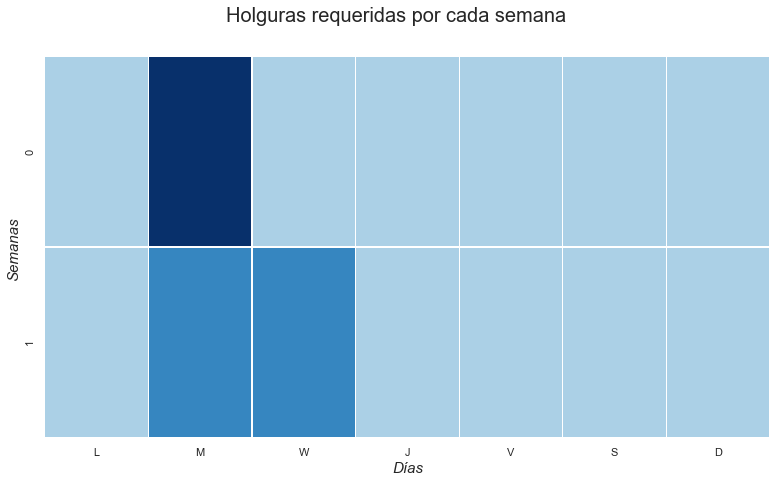

In [336]:
%matplotlib inline
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt

plt.figure(figsize=(13, 7))

plt.suptitle('Holguras requeridas por cada semana', size=20)
ax = sns.heatmap(df, fmt=".lf",linewidths=.25, square = False, cmap = "Blues",center = 0.5, cbar=False)
ax.set_xlabel("Días", style='italic', size=15)
ax.set_ylabel("Semanas", style='italic', size=15)

# Gurobi y flujo en redes

La idea de esta parte es revisar la resolución de un problema de flujo en redes clásico: TSP o Problema del Vendedor Viajero. De pasada, revisaremos el uso de la librería NetworkX, muy útil para grafos. El código de esta parte de la ayudantía está basado en el siguiente link, que resuelve un problema similar conocido como VRP o Vehicle Routing Problem.

In [337]:
import networkx as nx
from gurobipy import *
import matplotlib.pyplot as plt
import numpy as np
import random

random.seed(2122)
#3105, 1113 les muestra 3 subtours a la primera, y a la segunda lo resuelve; 
#2122, 3143 les muestra 2 subtours a la primera, y demora 3 iteraciones en resolver

In [338]:
def distancia(pos1, pos2):
    """
    distancia -- calcula distancia entre dos posiciones (de nodos) 
    Parámetros: 
        - pos1, pos2: tupla de posiciones (x,y)
    Retorna distancia entre dos puntos
    """
    x1 = pos1[0]
    y1 = pos1[1]
    x2 = pos2[0]
    y2 = pos2[1]
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [339]:
def graficar(nodos, arcos):
    """
    graficar -- grafica los nodos y arcos entregados
    Parámetros: 
        - nodos: diccionario con los id de los nodos de la forma {id nodo: (pos_x, pos_y)}
        - arcos: diccionario con los arcos de la forma {(cola,cabeza): costo}
    Retorna en pantalla un gráfico de lo solicitado.
    """
    G = nx.Graph() #esto genera un grafo no dirigido
    posiciones = dict()
    
    for nodo in nodos:
        G.add_node(nodo, pos=nodos[nodo])
        posiciones[nodo] = nodos[nodo]
        
# esto se hace exclusivamente si hay por ejemplo 2 opciones de forma de input de alguna variable, 
# aunque no es tan recomendado porque podría traer problemas. En este caso puede ser lista o dict.
    if isinstance(arcos, dict):
        for arco in arcos:
            G.add_edge(arco[0], arco[1], weight=arcos[arco])
    elif isinstance(arcos, list): 
        for arco in arcos:
            G.add_edge(arco[0], arco[1])
            
    nx.draw(G, pos=posiciones, with_labels=True, node_shape="o", font_size=14)
    plt.show()

In [340]:
def datos():
    """
    datos -- genera datos para el problema
    Retorna diccionario para nodos y para arcos
    """
    nodos = dict()
    arcos = dict()
    n = 10 #número de nodos
    
    for nodo in range(n):
        nodos[nodo] = (random.randint(0,30), random.randint(0,30)) #posición x,y del nodo
    for nodo in nodos: #recorre todos los id de los nodos ya creados
        for nodo2 in nodos:
            if nodo2 > nodo: #grafo completo no dirigido
                arcos[(nodo, nodo2)] = distancia(nodos[nodo], nodos[nodo2]) #{id arco: costo}
    
    return nodos, arcos

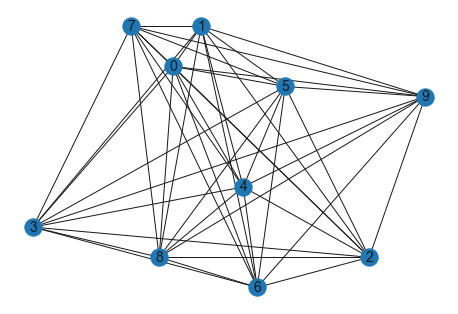

In [341]:
nodos, arcos = datos()
graficar(nodos, arcos)

Ahora que ya aprendimos a definir un grafo y graficarlo, podemos ir un poco más allá. El problema del TSP consiste en generar un ciclo a mínimo costo, que pase una vez por cada nodo. En esta primera etapa, resolveremos la relajación del problema.

In [342]:
def solve_TSP(nodos, arcos):
    """solve_TSP -- función que crea modelo en Gurobi y resuelve su relajación
    Parámetros:
        - nodos: diccionario con los id de los nodos de la forma {id nodo: (pos_x, pos_y)}
        - arcos: diccionario con los arcos de la forma {(cola,cabeza): costo} 
    Retorna arcos, modelo y variables de la relajación del TSP
    """
    model = Model("TSP")
    x = dict()
    c = dict()
    
    # definimos variables x binarias que tomen valor 1 si es que se usa ese arco, 0 e.o.c.
    for arco in arcos:
        x[arco[0], arco[1]] = model.addVar(vtype="binary", name="{},{}".format(arco[0], arco[1]))
        c[arco[0], arco[1]] = arcos[arco]
    model.update()

    # definimos restricción de que todos los nodos deben tener grado total (entrada + salida) de 2
    model.addConstrs((quicksum(x[k,i] for k in nodos if k<i) + quicksum(x[i,k] for k in nodos if k>i) == 2) for i in nodos)
    model.update()
    
    # definimos la función objetivo del problema, que es minimizar costos por arcos
    model.setObjective(quicksum(c[i,j]*x[i,j] for i in nodos for j in nodos if j>i), GRB.MINIMIZE)
    model.update()
    
    model.Params.OutputFlag = 0 # le pedimos a Gurobi que no nos printee todos sus cálculos (por defecto parámetro = 1)
    model.optimize() 
#     model.write("TSP_Relajado.lp")
    
    edges = dict()
    for (i,j) in x:
        if x[i,j].X > 0: # filtramos solamente a los arcos que toman valor mayor a 0 (que son los que uso en mi solución)
            edges[i,j] = distancia(nodos[i], nodos[j])
            
    return edges, model, x

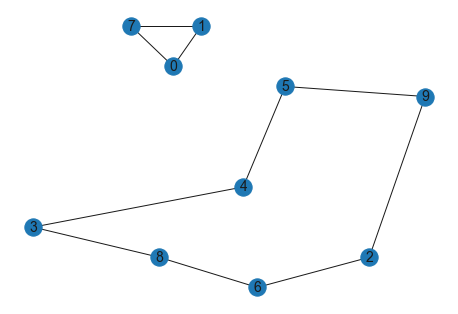

In [343]:
edges, modelo, variables = solve_TSP(nodos, arcos)
graficar(nodos, edges)

Acá nos damos cuenta que al resolver la versión relajada del problema, es posible que existan varios subciclos en nuestra solución. Para evitar esto, se recurre a lo que se conoce como 'lazy constraints', que se van agregando a medida que se van necesitando. Así, se evita aumentar la dimensionalidad del problema y se va resolviendo hasta que tengamos la solución que realmente nos sirve.

In [344]:
def subtours(arcos_usados, model, x):
    """subtours -- agrega restricción para evitar subtour específico que se le entrega
    Parámetros:
        - arcos_usados: lista de arcos de la solución actual
    Retorna True si es que se agregó un corte, Falso e.o.c.
    """
    G_aux = nx.Graph()
    G_aux.add_edges_from(arcos_usados)
    componentes = list(nx.connected_components(G_aux)) # generamos una lista de los nodos que están conectados entre sí
    print("Nodos conectados entre sí: {}".format(componentes))
    corte = False
            
    for S in componentes: #revisamos cada uno de los subciclos formados y agregamos restricción para ese subtour
        if len(S) == len(arcos_usados):
            return corte
        else: # len(S) < len(arcos_usados):
            model.addConstr(quicksum(x[i,j] for i in S for j in S if j > i) <= len(S)-1, f"subtour {S}")
            model.update()
            corte = True
    
    return corte

In [345]:
def modelo_con_cortes(model, x):
    """modelo_con_cortes -- continúa la resolución del modelo anterior, ahora llamado a las restricciones de subtours
    Parámetros:
        - model: modelo de Gurobi
        - x: diccionario con variables antes definidas en el modelo
    Retorna en pantalla un gráfico de cada una de las soluciones parciales y la final del problema.
    """
    while True: # re-optimizamos hasta que no queden subciclos
        model.optimize()
                    
        arcos_usados = []
        for (i,j) in x:
            if x[i,j].X > 0:
                arcos_usados.append((i,j))
        print("Arcos usados en la solución: {}".format(arcos_usados))
        
        if subtours(arcos_usados, model, x) == False:
            graficar(nodos, arcos_usados)
            print("Solución óptima encontrada")
            break
        else:
            graficar(nodos, arcos_usados)

Arcos usados en la solución: [(0, 1), (0, 7), (1, 7), (2, 6), (2, 9), (3, 4), (3, 8), (4, 5), (5, 9), (6, 8)]
Nodos conectados entre sí: [{0, 1, 7}, {2, 3, 4, 5, 6, 8, 9}]


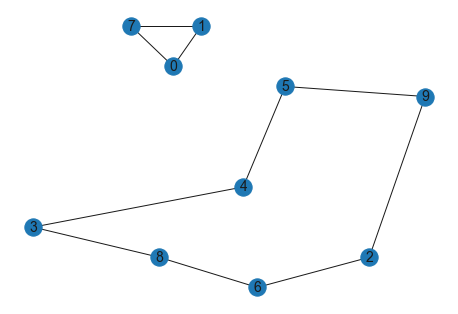

Arcos usados en la solución: [(0, 5), (0, 7), (1, 7), (1, 9), (2, 4), (2, 6), (3, 4), (3, 8), (5, 9), (6, 8)]
Nodos conectados entre sí: [{0, 1, 5, 7, 9}, {2, 3, 4, 6, 8}]


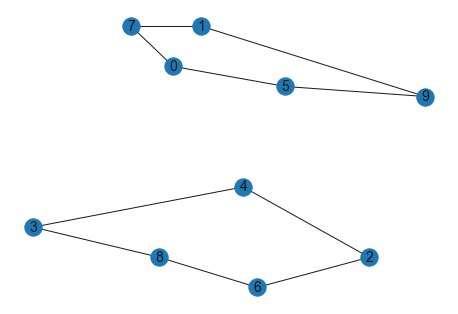

Arcos usados en la solución: [(0, 4), (0, 7), (1, 5), (1, 7), (2, 6), (2, 9), (3, 4), (3, 8), (5, 9), (6, 8)]
Nodos conectados entre sí: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}]


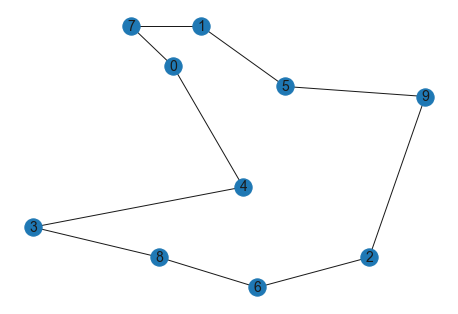

Solución óptima encontrada


In [346]:
modelo_con_cortes(modelo, variables)